# Statistical comparison of models using grid search
- `GridSearchCV`를 사용해 학습 및 평가된 모델의 성능을 통계적으로 비교하는 방법

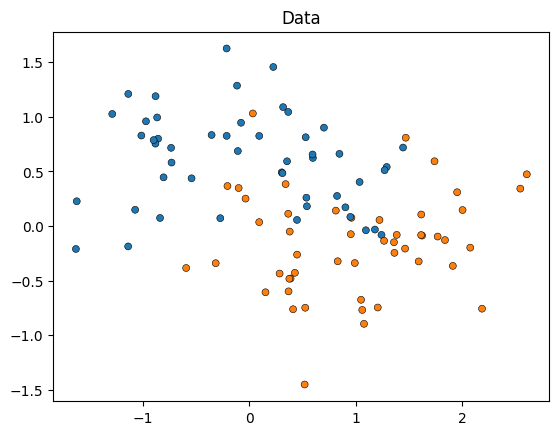

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_moons

X, y = make_moons(noise=0.352, random_state=1, n_samples=100)

sns.scatterplot(
    x=X[:, 0], y=X[:, 1], hue=y, marker="o", s=25, edgecolor="k", legend=False
).set_title("Data")
plt.show()

In [2]:
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.svm import SVC

param_grid = [
    {"kernel": ["linear"]},
    {"kernel": ["poly"], "degree": [2, 3]},
    {"kernel": ["rbf"]},
]

svc = SVC(random_state=0)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=0)

search = GridSearchCV(estimator=svc, param_grid=param_grid, scoring="roc_auc", cv=cv)
search.fit(X, y)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=10, random_state=0),
             estimator=SVC(random_state=0),
             param_grid=[{'kernel': ['linear']},
                         {'degree': [2, 3], 'kernel': ['poly']},
                         {'kernel': ['rbf']}],
             scoring='roc_auc')

In [3]:
import pandas as pd

results_df = pd.DataFrame(search.cv_results_)
results_df = results_df.sort_values(by=["rank_test_score"])
results_df = results_df.set_index(
    results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
).rename_axis("kernel")
results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
rbf,{'kernel': 'rbf'},1,0.9400,0.079297
linear,{'kernel': 'linear'},2,0.9300,0.077846
3_poly,"{'degree': 3, 'kernel': 'poly'}",3,0.9044,0.098776
2_poly,"{'degree': 2, 'kernel': 'poly'}",4,0.6852,0.169106


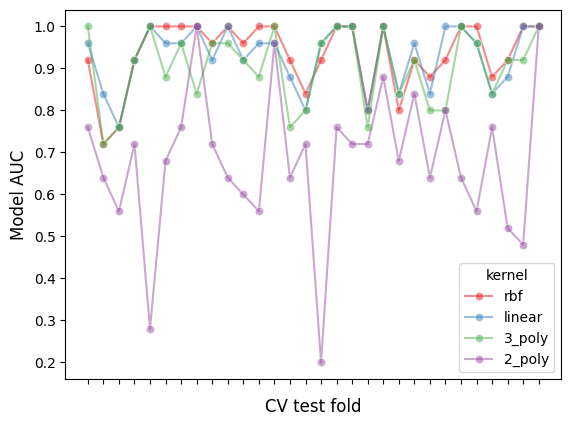

Correlation of models:
 kernel       rbf    linear    3_poly    2_poly
kernel                                        
rbf     1.000000  0.882561  0.783392  0.351390
linear  0.882561  1.000000  0.746492  0.298688
3_poly  0.783392  0.746492  1.000000  0.355440
2_poly  0.351390  0.298688  0.355440  1.000000


In [4]:
# 성능에 따라 정렬된 모델 점수의 df 생성
model_scores = results_df.filter(regex=r"split\d*_test_score")

# cv fold 와 AUC scores 간의 의존성 30가지 예시 플롯
fig, ax = plt.subplots()
sns.lineplot(
    data=model_scores.transpose().iloc[:30],
    dashes=False,
    palette="Set1",
    marker="o",
    alpha=0.5,
    ax=ax,
)
ax.set_xlabel("CV test fold", size=12, labelpad=10)
ax.set_ylabel("Model AUC", size=12)
ax.tick_params(bottom=True, labelbottom=False)
plt.show()

# fold간 AUC score의 상관관계 출력
print(f"Correlation of models:\n {model_scores.transpose().corr()}")

## Comparing two models: frequentist approach

In [5]:
import numpy as np
from scipy.stats import t


def corrected_std(differences, n_train, n_test):
    """Nadeau and Bengio의 접근 방식을 사용하여 표준 편차를 보정

    Parameters
    ----------
    차이점 : 모양 배열 (n_samples,)
        두 모델의 점수 지표의 차이를 포함하는 벡터
    n_train : int
        훈련 세트의 샘플 수
    n_test : int
        테스트 세트의 샘플 수

    Returns
    -------
    corrected_std : float
        차이 집합의 분산 보정 표준 편차이다.
    """
    # kr = k * r, r * 반복된 k-fold crossvalidation,
    # kr은 모델이 평가된 횟수와 같다.
    kr = len(differences)
    corrected_var = np.var(differences, ddof=1) * (1 / kr + n_test / n_train)
    corrected_std = np.sqrt(corrected_var)
    return corrected_std


def compute_corrected_ttest(differences, df, n_train, n_test):
    """보정된 분산으로 right-tailed 짝을 이룬 t-test를 계산한다.

    Parameters
    ----------
    차이점 : 배열과 비슷한 형태 (n_samples,)
        두 모델의 점수 메트릭의 차이를 포함하는 벡터
    df : int
        자유도
    n_train : int
        훈련 집합의 샘플 수
    n_test : int
        테스트 집합의 샘플 수

    Returns
    -------
    t_stat : float
        분산 보정된 t-stat
    p_val : float
        분산 보정된 p-value.
    """
    mean = np.mean(differences)
    std = corrected_std(differences, n_train, n_test)
    t_stat = mean / std
    p_val = t.sf(np.abs(t_stat), df)  # right-tailed t-test
    return t_stat, p_val

In [6]:
model_1_scores = model_scores.iloc[0].values  # 베스트 모델 점수
model_2_scores = model_scores.iloc[1].values  # 두 번째로 우수한 모델 점수

differences = model_1_scores - model_2_scores

n = differences.shape[0]  # 테스트 세트의 수
df = n - 1
n_train = len(list(cv.split(X, y))[0][0])
n_test = len(list(cv.split(X, y))[0][1])

t_stat, p_val = compute_corrected_ttest(differences, df, n_train, n_test)
print(f"Corrected t-value: {t_stat:.3f}\nCorrected p-value: {p_val:.3f}")

Corrected t-value: 0.750
Corrected p-value: 0.227


In [7]:
t_stat_uncorrected = np.mean(differences) / np.sqrt(np.var(differences, ddof=1) / n)
p_val_uncorrected = t.sf(np.abs(t_stat_uncorrected), df)

print(
    f"Uncorrected t-value: {t_stat_uncorrected:.3f}\n"
    f"Uncorrected p-value: {p_val_uncorrected:.3f}"
)

Uncorrected t-value: 2.611
Uncorrected p-value: 0.005


## Comparing two models: Bayesian approach

In [8]:
# 랜덤 변수 초기화
t_post = t(
    df, loc=np.mean(differences), scale=corrected_std(differences, n_train, n_test)
)

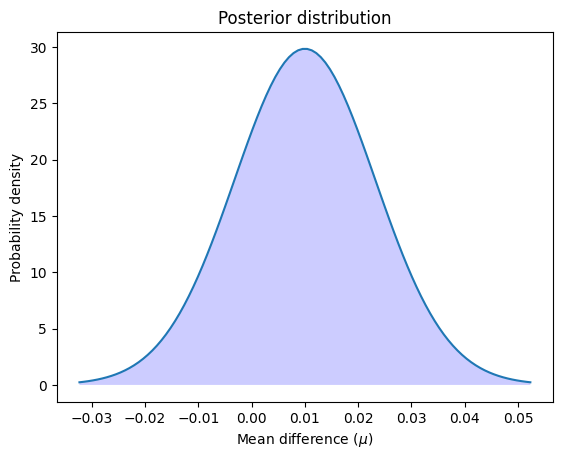

In [9]:
x = np.linspace(t_post.ppf(0.001), t_post.ppf(0.999), 100)

plt.plot(x, t_post.pdf(x))
plt.xticks(np.arange(-0.04, 0.06, 0.01))
plt.fill_between(x, t_post.pdf(x), 0, facecolor="blue", alpha=0.2)
plt.ylabel("Probability density")
plt.xlabel(r"Mean difference ($\mu$)")
plt.title("Posterior distribution")
plt.show()

In [10]:
better_prob = 1 - t_post.cdf(0)

print(
    f"Probability of {model_scores.index[0]} being more accurate than "
    f"{model_scores.index[1]}: {better_prob:.3f}"
)
print(
    f"Probability of {model_scores.index[1]} being more accurate than "
    f"{model_scores.index[0]}: {1 - better_prob:.3f}"
)

Probability of rbf being more accurate than linear: 0.773
Probability of linear being more accurate than rbf: 0.227


### Region of Practical Equivalence

In [11]:
rope_interval = [-0.01, 0.01]
rope_prob = t_post.cdf(rope_interval[1]) - t_post.cdf(rope_interval[0])

print(
    f"Probability of {model_scores.index[0]} and {model_scores.index[1]} "
    f"being practically equivalent: {rope_prob:.3f}"
)

Probability of rbf and linear being practically equivalent: 0.432


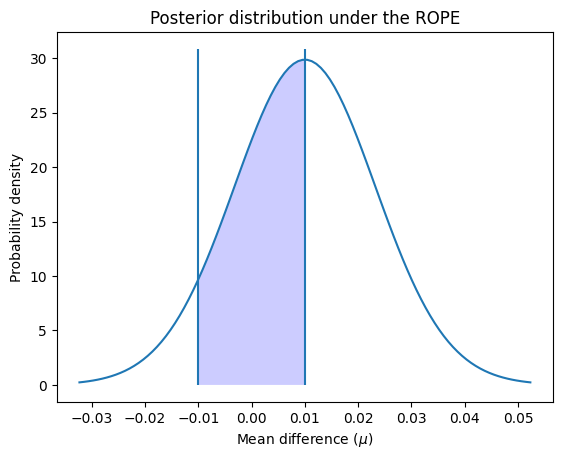

In [12]:
x_rope = np.linspace(rope_interval[0], rope_interval[1], 100)

plt.plot(x, t_post.pdf(x))
plt.xticks(np.arange(-0.04, 0.06, 0.01))
plt.vlines([-0.01, 0.01], ymin=0, ymax=(np.max(t_post.pdf(x)) + 1))
plt.fill_between(x_rope, t_post.pdf(x_rope), 0, facecolor="blue", alpha=0.2)
plt.ylabel("Probability density")
plt.xlabel(r"Mean difference ($\mu$)")
plt.title("Posterior distribution under the ROPE")
plt.show()

In [13]:
cred_intervals = []
intervals = [0.5, 0.75, 0.95]

for interval in intervals:
    cred_interval = list(t_post.interval(interval))
    cred_intervals.append([interval, cred_interval[0], cred_interval[1]])

cred_int_df = pd.DataFrame(
    cred_intervals, columns=["interval", "lower value", "upper value"]
).set_index("interval")
cred_int_df

,lower value,upper value
interval,,
0.50,0.000977,0.019023
0.75,-0.005422,0.025422
0.95,-0.016445,0.036445


## Pairwise comparison of all models: frequntist approach

In [14]:
from itertools import combinations
from math import factorial

n_comparisons = factorial(len(model_scores)) / (
    factorial(2) * factorial(len(model_scores) - 2)
)
pairwise_t_test = []

for model_i, model_k in combinations(range(len(model_scores)), 2):
    model_i_scores = model_scores.iloc[model_i].values
    model_k_scores = model_scores.iloc[model_k].values
    differences = model_i_scores - model_k_scores
    t_stat, p_val = compute_corrected_ttest(differences, df, n_train, n_test)
    p_val *= n_comparisons  # Bonferroni 보정 구현
    # Bonferroni 1보다 높은 p-values 
    p_val = 1 if p_val > 1 else p_val
    pairwise_t_test.append(
        [model_scores.index[model_i], model_scores.index[model_k], t_stat, p_val]
    )

pairwise_comp_df = pd.DataFrame(
    pairwise_t_test, columns=["model_1", "model_2", "t_stat", "p_val"]
).round(3)
pairwise_comp_df

,model_1,model_2,t_stat,p_val
0,rbf,linear,0.750,1.000
1,rbf,3_poly,1.657,0.302
2,rbf,2_poly,4.565,0.000
3,linear,3_poly,1.111,0.807
4,linear,2_poly,4.276,0.000
5,3_poly,2_poly,3.851,0.001


## Pairwise comparison of all models: Bayesian approach

In [15]:
pairwise_bayesian = []

for model_i, model_k in combinations(range(len(model_scores)), 2):
    model_i_scores = model_scores.iloc[model_i].values
    model_k_scores = model_scores.iloc[model_k].values
    differences = model_i_scores - model_k_scores
    t_post = t(
        df, loc=np.mean(differences), scale=corrected_std(differences, n_train, n_test)
    )
    worse_prob = t_post.cdf(rope_interval[0])
    better_prob = 1 - t_post.cdf(rope_interval[1])
    rope_prob = t_post.cdf(rope_interval[1]) - t_post.cdf(rope_interval[0])

    pairwise_bayesian.append([worse_prob, better_prob, rope_prob])

pairwise_bayesian_df = pd.DataFrame(
    pairwise_bayesian, columns=["worse_prob", "better_prob", "rope_prob"]
).round(3)

pairwise_comp_df = pairwise_comp_df.join(pairwise_bayesian_df)
pairwise_comp_df

,model_1,model_2,t_stat,p_val,worse_prob,better_prob,rope_prob
0,rbf,linear,0.750,1.000,0.068,0.500,0.432
1,rbf,3_poly,1.657,0.302,0.018,0.882,0.100
2,rbf,2_poly,4.565,0.000,0.000,1.000,0.000
3,linear,3_poly,1.111,0.807,0.063,0.750,0.187
4,linear,2_poly,4.276,0.000,0.000,1.000,0.000
5,3_poly,2_poly,3.851,0.001,0.000,1.000,0.000
